## Project Objective

Spam detection is a key application of Machine Learning, widely used by email service providers to automatically classify unwanted emails as 'Junk Mail'. 

In this project, we'll use the **Naive Bayes algorithm** to build a model that can classify SMS messages as spam or not spam using the [SMS Spam Collection dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). Spam messages often contain words like 'free', 'win', 'cash', 'prize', and use capital letters and exclamation marks to grab attention. Our goal is to train a model that can recognize these patterns and accurately identify spam.

In short, the Bayes theorem calculates the probability of a certain event happening(in our case, a message being  spam) based on the joint probabilistic distributions of certain other events(in our case, the appearance of certain words in a message).

This task is a **binary classification problem**, where each message is categorized as either 'Spam' or 'Not Spam'. Since we have a labeled dataset, it falls under **supervised learning**, as the model will learn from labeled examples to make future predictions.


### Understanding our dataset ### 


We will be using a [dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from the UCI Machine Learning repository which has a very good collection of datasets for experimental research purposes. 


 ** Here's a preview of the data: ** 

- this is image from the dataset :
<img src="images/dqnb.png" height="1242" width="1242">

The columns in the data set are currently not named and as you can see, there are 2 columns. 

The first column takes two values, 'ham' which signifies that the message is not spam, and 'spam' which signifies that the message is spam. 

The second column is the text content of the SMS message that is being classified.

## importing data
* Import the dataset into a pandas dataframe using the read_table method. Because this is a tab separated dataset we will be using '\t' as the value for the 'sep' argument which specifies this format. 
* Also, rename the column names by specifying a list ['label, 'sms_message'] to the 'names' argument of read_table().

In [1]:
import pandas as pd

df = pd.read_csv('SMSSpamCollection',
                   sep='\t', 
                   header=None,  # ensures that pandas reads the data without treating any row as a header.
                   names=['label', 'sms_message'] # name the columns
                )

# printing first 5 rows
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Preprocessing 

Now that we have a basic understanding of our dataset, let's convert the labels to binary values. We'll use 0 to represent 'ham' (not spam) and 1 to represent 'spam' to make computation easier.

Why is this step necessary? Scikit-learn requires numerical inputs for its models. If we leave the labels as strings, scikit-learn will internally convert them to unknown float values. Although the model would still work with string labels, we might face issues later when calculating performance metrics like precision and recall.

To avoid complications, it's good practice to convert categorical values into integers before feeding them into the model.


In [2]:
# mapping "ham" to 0 and "spam" to 1
df['label'] = df["label"].map({'ham':0, 'spam':1})

In [3]:
# returns (rows, columns)
print(df.shape)
df.head() 

(5572, 2)


,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
spam_percentage = (df[df["label"] == 1].shape[0] / df.shape[0]) * 100
spam_percentage

13.406317300789663

In [5]:
ham_percentage = (df[df["label"] == 0].shape[0] / df.shape[0]) * 100
ham_percentage

86.59368269921033

### In this case, where the dataset consists of 87% ham (not spam) and 13% spam, it's important to focus on metrics beyond just accuracy, such as precision, recall, and the F1 score (we will discuss it later in model testing)

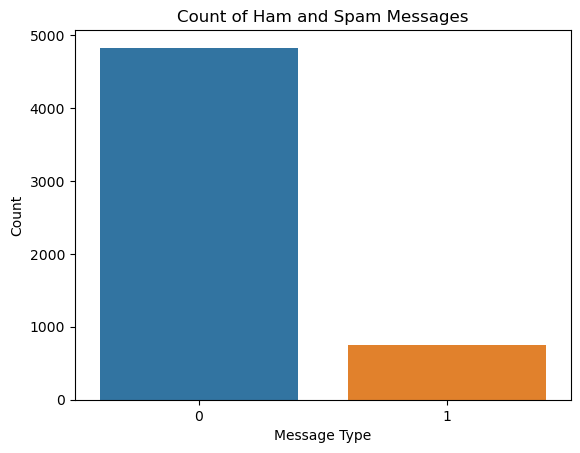

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Counting the occurrences of each label
count_data = df['label'].value_counts().reset_index()
count_data.columns = ['label', 'count']

# Creating the bar chart
sns.barplot(x='label', y='count', data=count_data)

# Adding title and labels
plt.title('Count of Ham and Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')

# Display the plot
plt.show()


In [7]:
df.info() # num of non-null rows in 2 columns eqaull to num of rows (data is clean there is no nulls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        5572 non-null   int64 
 1   sms_message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


### Bag of Words (BoW)

Why we will use it ? , becuase Machine learning algorithms require numerical data, but text-heavy data (like SMS or emails) need to be converted into numbers for processing.

Bag of Words Concept:
   - BoW is a technique that converts text data into numerical form by counting word frequencies in a text.
   - The order of the words is ignored, and each word is treated individually.
   - Converts a collection of documents into a matrix where each row is a document, and each column represents a word (token).        The values in the matrix indicate word frequency.

these preprocessing steps are applied by default in CountVectorizer() when fitting the model

### To handle this
we will be using sklearn's CountVectorizer method which does the following:
- Tokenization: Splits text into individual words and assigns each word an integer ID.
- Word Count: Counts how often each token appea

### you should consider Key Parameters in CountVectorizer:
- Lowercasing: Converts all words to lowercase automatically (default lowercase=True), so that 'He' and 'he' are treated the same.
- Punctuation: Ignores punctuation (controlled by token_pattern parameter).
- Stop Words: Removes common words like 'the', 'and', etc., using the stop_words='english' parameter, as stop words can skew results.

### Implementing Bag of Words in scikit-learn ###

as we had a solid understanding of what is happening behind the scenes in the `sklearn.feature_extraction.text.CountVectorizer` method of scikit-learn. 

We will now implement `sklearn.feature_extraction.text.CountVectorizer` method in the next step.

In [8]:
# Import the sklearn.feature_extraction.text.CountVectorizer method and create an instance of it called 'count_vector'. 
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

### Training and testing sets ###


In [9]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['sms_message'], 
                                                    df['label'], 
                                                    random_state=1)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


### Applying Bag of Words processing to our dataset. ###

Now that we have split the data, our next objective is: Bag of words and convert our data into the desired matrix format. To do this we will be using CountVectorizer() as we did before. There are two  steps to consider here:

* Firstly, we have to fit our training data (`X_train`) into `CountVectorizer()` and return the matrix.
* Secondly, we have to transform our testing data (`X_test`) to return the matrix. 

Note that `X_train` is our training data for the 'sms_message' column in our dataset and we will be using this to train our model. 

`X_test` is our testing data for the 'sms_message' column and this is the data we will be using(after transformation to a matrix) to make predictions on. We will then compare those predictions with `y_test` in a later step. 

In [10]:
# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train).toarray()

# Transform testing data and return the matrix.
testing_data = count_vector.transform(X_test).toarray()

### Step 5: Naive Bayes Implementation Using Scikit-Learn ###

We will implement the Naive Bayes algorithm using scikit-learn's built-in Naive Bayes methods. For this task, we'll use the `MultinomialNB` class from `sklearn.naive_bayes`, which is particularly suited for classification with discrete features like word counts in text data.

While there are other implementations, such as `GaussianNB` for continuous data that follows a normal distribution, `MultinomialNB` works best when dealing with integer

In [11]:
'''
We have loaded the training data into the variable 'training_data' and the testing data into the 
variable 'testing_data'.

Import the MultinomialNB classifier and fit the training data into the classifier using fit(). Name the classifier
'naive_bayes'. we will be training the classifier using 'training_data' and y_train' from our split earlier. 

'''

from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)
training_data.shape

(4179, 7456)

In [12]:
'''
Now that our algorithm has been trained using the training data set we can now make some predictions on the test data
stored in 'testing_data' using predict(). Save your predictions into the 'predictions' variable.
'''
predictions = naive_bayes.predict(testing_data)

### Step 6: Evaluating Our Model ###

Having made predictions on our test set, the next step is to evaluate the performance of our model. Several metrics can be utilized for this purpose:

- **Accuracy**: This metric indicates the proportion of correct predictions made by the classifier. It is calculated as the ratio of correct predictions to the total number of predictions, expressed as:


- **Precision**: This metric measures the accuracy of the positive predictions. It represents the ratio of true positives (messages correctly classified as spam) to all predicted positives (messages classified as spam), formulated as:


- **Recall (Sensitivity)**: This metric assesses the ability of the classifier to identify actual spam messages. It is defined as the ratio of true positives to the total number of actual spam messages, expressed as:

In scenarios where the classification distribution is imbalanced, such as our case where spam messages are rare, accuracy alone may not be a reliable indicator of model performance. For instance, if out of 100 messages, only 2 are spam, a model could achieve a high accuracy score by primarily predicting non-spam. 

Thus, precision and recall become critical metrics. These two can be combined to calculate the **F1 Score**, which is the weighted harmonic mean of precision and recall,


In [13]:
'''
We will be using all 4 metrics to make sure our model does well. For all 4 metrics whose values can range from 0 to 1, 
having a score as close to 1 as possible is a good indicator of how well our model is doing.
'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))

print('Precision score: ', format(precision_score(y_test, predictions))) # how many already spam from that you siad they spam
print('Recall score: ', format(recall_score(y_test, predictions))) # how many you decide it spam from the whole num of the spam
print('F1 score: ', format(f1_score(y_test, predictions))) #combination of recall and percision

Accuracy score:  0.9885139985642498
Precision score:  0.9720670391061452
Recall score:  0.9405405405405406
F1 score:  0.9560439560439562


### function to predict

In [14]:
# function to predict whether a given string is spam or ham based on your trained model

def predict_spam_or_ham(message):
    """
    Predicts whether a given SMS message is spam or ham.

    Parameters:
    message (str): The SMS message to be classified.

    Returns:
    int: 1 if the message is spam, 0 if it is ham.
    """
    # Preprocess the message: Transform the message into a format suitable for prediction
    transformed_message = count_vector.transform([message])
    # Predict using the trained Naive Bayes model
    prediction = naive_bayes.predict(transformed_message)
    return prediction[0]  # Return the prediction (0 or 1)


### Example usage

In [15]:
test_message_1 = "Hello, I am Sherif. My team won the World Cup!"  # ham
test_message_2 = "You have won a £100,000 Prize!"  # spam

print(f'Message: "{test_message_1}" - Prediction: {"Spam" if predict_spam_or_ham(test_message_1) == 1 else "Ham"}')
print(f'Message: "{test_message_2}" - Prediction: {"Spam" if predict_spam_or_ham(test_message_2) == 1 else "Ham"}')

Message: "Hello, I am Sherif. My team won the World Cup!" - Prediction: Ham
Message: "You have won a £100,000 Prize!" - Prediction: Spam
